
Используя данные датасета реализовать задачу кластеризации. Необходимо выделить страны экспортеры и страны импортеры пшеницы. Выделить лидеров рынка по производству и по внутреннему потреблению. Оценить процент импорта/экспорта относительно внутреннего потребления.

Подготовьте данные - оставьте только страны

Выберите метод кластеризации:

Иерархическая кластеризация

DBSCAN

k-Means

Создайте матрицу ошибок

Оценить качество полученной модели используя precision, recall и F-меру

Оценить модель в целом, не привязываясь к конкретному порогу:

AUC-ROC (или ROC AUC) — площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve )

Logistic Loss

Оформить результаты.

В процессе работы этапы иллюстрировать графиками графиками.


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('WASDE-DATA.csv')
data.head()

,code,report_month,region,commodity,item,year,period,value,min_value,max_value
0,WHEAT_WORLD_19,2023-09,World Less China,Wheat,Production,2023/24 Proj.,Sep,650.34,NaN,NaN
1,WHEAT_WORLD_19,2023-09,World Less China,Wheat,Production,2023/24 Proj.,Aug,656.37,NaN,NaN
2,WHEAT_WORLD_19,2023-09,World Less China,Wheat,Imports,2023/24 Proj.,Sep,194.62,NaN,NaN
3,WHEAT_WORLD_19,2023-09,World Less China,Wheat,Imports,2023/24 Proj.,Aug,195.39,NaN,NaN
4,WHEAT_WORLD_19,2023-09,World Less China,Wheat,Exports,2023/24 Proj.,Sep,206.44,NaN,NaN


In [3]:
data.drop(columns = ['code', 'commodity', 'year', 'period', 'min_value', 'max_value'], inplace = True)
data.head()

,report_month,region,item,value
0,2023-09,World Less China,Production,650.34
1,2023-09,World Less China,Production,656.37
2,2023-09,World Less China,Imports,194.62
3,2023-09,World Less China,Imports,195.39
4,2023-09,World Less China,Exports,206.44


In [4]:
data.item.value_counts()

Production           1429
Imports              1429
Exports              1429
Ending Stocks        1429
Domestic Total 2/    1429
Domestic Feed        1428
Beginning Stocks     1427
Name: item, dtype: int64

In [5]:
# Оставляем только нужные строки для анализа (Exports, Imports, Production, Domestic Total)
selected_items = ['Exports', 'Imports', 'Production', 'Domestic Feed']
data = data[data['item'].isin(selected_items)]

In [6]:
# Группируем данные по регионам и суммируем значения для каждого региона
data_grouped = data.groupby(['region', 'item'])['value'].sum().unstack().fillna(0)
data_grouped

item,Domestic Feed,Exports,Imports,Production
region,,,,
Argentina,3.45,756.50,0.39,1127.38
Australia,280.40,1403.00,13.40,1911.60
Bangladesh,24.95,0.00,407.70,69.44
Brazil,36.90,130.25,400.10,510.55
Canada,248.20,1455.90,37.80,1977.27
China,2000.00,59.50,618.50,8613.96
EU-27+UK 5/,391.00,214.50,48.00,1086.20
European Union 5/,2488.00,1914.00,328.90,7511.99
India,407.50,240.35,2.73,6791.40


In [7]:
data_grouped_clear = data_grouped.drop(['EU-27+UK 5/', 'European Union 5/', 'Major Exporters 4/', 'Major Importers 6/', 'N. Africa 7/', 'Sel. Mideast 8/', 'Southeast Asia 9/', 'World 3/', 'World Less China', 'Total Foreign'])
data_grouped_clear

item,Domestic Feed,Exports,Imports,Production
region,,,,
Argentina,3.45,756.50,0.39,1127.38
Australia,280.40,1403.00,13.40,1911.60
Bangladesh,24.95,0.00,407.70,69.44
Brazil,36.90,130.25,400.10,510.55
Canada,248.20,1455.90,37.80,1977.27
China,2000.00,59.50,618.50,8613.96
India,407.50,240.35,2.73,6791.40
Japan,41.55,18.62,354.55,68.24
Kazakhstan,89.05,499.90,60.30,835.03


# Лидеры страны экспортеры и страны импортеры пшеницы

In [8]:
data_ex_im = data_grouped_clear[['Exports', 'Imports']]
data_ex_im

item,Exports,Imports
region,,
Argentina,756.50,0.39
Australia,1403.00,13.40
Bangladesh,0.00,407.70
Brazil,130.25,400.10
Canada,1455.90,37.80
China,59.50,618.50
India,240.35,2.73
Japan,18.62,354.55
Kazakhstan,499.90,60.30


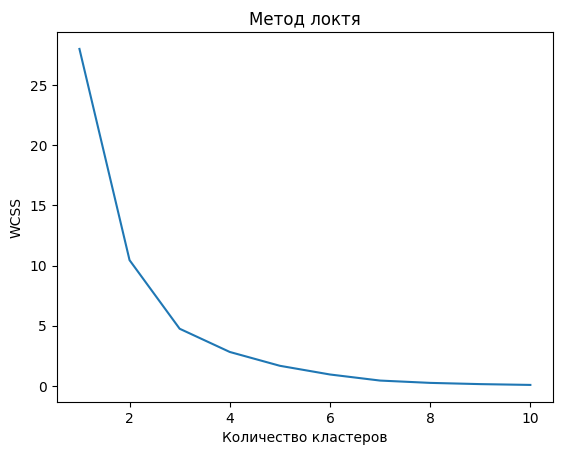

In [9]:
# Масштабируем данные
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_ex_im)
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Отобразим график метода локтя
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')  # WCSS - Within-Cluster Sum of Squares
plt.show()

Оптимальное количество кластеров находится там, где график начинает убывать менее существенно.

Выбераем количество кластеров, где происходит снижение "скорости" убывания WCSS, и это количество будет оптимальным.

In [10]:
# Применяем KMeans с выбранным количеством кластеров
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=244)
cluster_labels = kmeans.fit_predict(scaled_data)

In [11]:
# Добавим метки кластеров к данным
data_ex_im['Cluster'] = cluster_labels
data_ex_im

<ipython-input-11-04a2cab810f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ex_im['Cluster'] = cluster_labels


item,Exports,Imports,Cluster
region,,,
Argentina,756.50,0.39,0
Australia,1403.00,13.40,2
Bangladesh,0.00,407.70,1
Brazil,130.25,400.10,1
Canada,1455.90,37.80,2
China,59.50,618.50,1
India,240.35,2.73,0
Japan,18.62,354.55,1
Kazakhstan,499.90,60.30,0


Теперь у нас есть данные, разделенные на кластеры. И мы можем провести дополнительный анализ для выделения лидеров рынка, оценки импорта/экспорта и т.д., используя информацию о кластерах.

In [12]:
#Средние значения для каждого кластера
cluster_means = data_ex_im.groupby('Cluster').mean()
cluster_means

item,Exports,Imports
Cluster,,
0,387.1125,40.03
1,48.2340,429.31
2,1573.4960,58.22


In [13]:
leader_cluster_ex = cluster_means['Exports'].idxmax()
leader_region_ex = data_ex_im[data_ex_im['Cluster'] == leader_cluster_ex]
leader_region_ex

item,Exports,Imports,Cluster
region,,,
Australia,1403.00,13.4,2
Canada,1455.90,37.8,2
Russia,2529.50,25.7,2
Ukraine,1030.30,5.7,2
United States,1448.78,208.5,2


In [14]:
leader_cluster_im = cluster_means['Imports'].idxmax()
leader_region_im = data_ex_im[data_ex_im['Cluster'] == leader_cluster_im]
leader_region_im

item,Exports,Imports,Cluster
region,,,
Bangladesh,0.00,407.70,1
Brazil,130.25,400.10,1
China,59.50,618.50,1
Japan,18.62,354.55,1
Nigeria,32.80,365.70,1


In [15]:
print(f"Лидеры по Экспорту: Кластер {leader_cluster_ex},\n Регионы {leader_region_ex.index.values}\n")
print(f"Лидеры по Импорту: Кластер {leader_cluster_im},\n Регионы {leader_region_im.index.values}\n")

Лидеры по Экспорту: Кластер 2,
 Регионы ['Australia' 'Canada' 'Russia' 'Ukraine' 'United States']

Лидеры по Импорту: Кластер 1,
 Регионы ['Bangladesh' 'Brazil' 'China' 'Japan' 'Nigeria']



#Лидеры рынка по производству и по внутреннему потреблению

In [16]:
data_dom_prod = data_grouped_clear[['Domestic Feed', 'Production']]
data_dom_prod

item,Domestic Feed,Production
region,,
Argentina,3.45,1127.38
Australia,280.40,1911.60
Bangladesh,24.95,69.44
Brazil,36.90,510.55
Canada,248.20,1977.27
China,2000.00,8613.96
India,407.50,6791.40
Japan,41.55,68.24
Kazakhstan,89.05,835.03


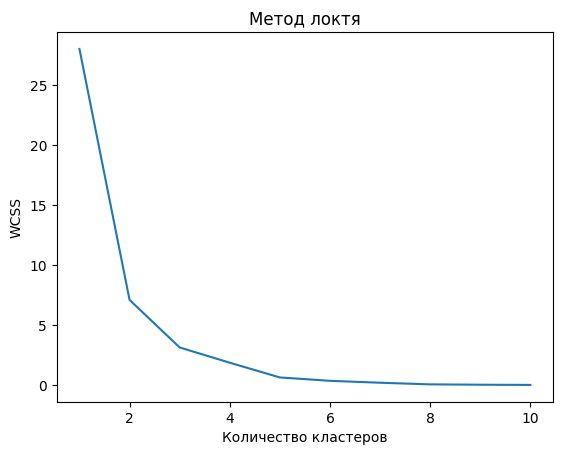

In [17]:
# Масштабируем данные
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_dom_prod)
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Отобразим график метода локтя
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')  # WCSS - Within-Cluster Sum of Squares
plt.show()

In [18]:
# Применяем KMeans с выбранным количеством кластеров
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=144)
cluster_labels = kmeans.fit_predict(scaled_data)

In [19]:
# Добавим метки кластеров к данным
data_dom_prod['Cluster'] = cluster_labels
data_dom_prod

<ipython-input-19-ce5661dbb2a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dom_prod['Cluster'] = cluster_labels


item,Domestic Feed,Production,Cluster
region,,,
Argentina,3.45,1127.38,1
Australia,280.40,1911.60,1
Bangladesh,24.95,69.44,1
Brazil,36.90,510.55,1
Canada,248.20,1977.27,1
China,2000.00,8613.96,0
India,407.50,6791.40,0
Japan,41.55,68.24,1
Kazakhstan,89.05,835.03,1


Теперь у нас есть данные, разделенные на кластеры. И мы можем провести дополнительный анализ для выделения лидеров рынка, оценки импорта/экспорта и т.д., используя информацию о кластерах.

In [20]:
#Средние значения для каждого кластера
cluster_means = data_dom_prod.groupby('Cluster').mean()
cluster_means

item,Domestic Feed,Production
Cluster,,
0,1198.833333,6875.923333
1,135.753636,1072.228182


In [21]:
leader_cluster_dom = cluster_means['Domestic Feed'].idxmax()
leader_region_dom = data_dom_prod[data_dom_prod['Cluster'] == leader_cluster_dom]
leader_region_dom

item,Domestic Feed,Production,Cluster
region,,,
China,2000.0,8613.96,0
India,407.5,6791.40,0
Russia,1189.0,5222.41,0


In [22]:
leader_cluster_prod = cluster_means['Production'].idxmax()
leader_region_prod = data_dom_prod[data_dom_prod['Cluster'] == leader_cluster_prod]
leader_region_prod

item,Domestic Feed,Production,Cluster
region,,,
China,2000.0,8613.96,0
India,407.5,6791.40,0
Russia,1189.0,5222.41,0


In [23]:
print(f"Лидеры по производству: Кластер {leader_cluster_dom},\n Регионы {leader_region_dom.index.values}\n")
print(f"Лидеры по внутреннему потреблению: Кластер {leader_cluster_prod},\n Регионы {leader_region_prod.index.values}\n")

Лидеры по производству: Кластер 0,
 Регионы ['China' 'India' 'Russia']

Лидеры по внутреннему потреблению: Кластер 0,
 Регионы ['China' 'India' 'Russia']



#Процент импорта/экспорта относительно внутреннего потребления

In [24]:
data_grouped_clear['Export_Percentage'] = round((data_grouped_clear['Exports'] / data_grouped_clear['Domestic Feed']) * 100, 2)
data_grouped_clear['Import_Percentage'] = round((data_grouped_clear['Imports'] / data_grouped_clear['Domestic Feed']) * 100, 2)
data_grouped_clear

item,Domestic Feed,Exports,Imports,Production,Export_Percentage,Import_Percentage
region,,,,,,
Argentina,3.45,756.50,0.39,1127.38,21927.54,11.30
Australia,280.40,1403.00,13.40,1911.60,500.36,4.78
Bangladesh,24.95,0.00,407.70,69.44,0.00,1634.07
Brazil,36.90,130.25,400.10,510.55,352.98,1084.28
Canada,248.20,1455.90,37.80,1977.27,586.58,15.23
China,2000.00,59.50,618.50,8613.96,2.97,30.93
India,407.50,240.35,2.73,6791.40,58.98,0.67
Japan,41.55,18.62,354.55,68.24,44.81,853.31
Kazakhstan,89.05,499.90,60.30,835.03,561.37,67.71
